# Homework 5: Carry Trade - Jingwen Li

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import quandl
import functools
import seaborn as sns
import nasdaqdatalink as ndl
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import norm, pearsonr, zscore
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

### zero and spot curves function

In [3]:
def bond_price(zcb, coupon_rate, tenor):
    times = np.arange(tenor,0, step=-0.5)[::-1]
    if times.shape[0]==0:
        p = 1.0
    else:
        r = np.interp(times, zcb.index.values, zcb.values[:,0]) # Linear interpolation
        p = np.exp(-tenor*r[-1]) + 0.5 * coupon_rate * np.exp(-r*times).sum()
    return p

In [4]:
def compute_zcb_curve(spot_rates_curve):
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        spot = spot_rates_curve[curve]
        for tenor, spot_rate in spot.iteritems():            
            if tenor>0.001:
                times = np.arange(tenor-0.25, 0, step=-0.25)[::-1]
                coupon_quarter = 0.25*spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values) # Linear interpolation
                preceding_coupons_val = (coupon_quarter*np.exp(-z*times)).sum()
                zcb_rates[curve][tenor] = -np.log((1-preceding_coupons_val)/(1+coupon_quarter))/tenor
    return zcb_rates


## 1. Obtaining Data

### a. Here I coded a function to fetch all the data points for each currency:
    
- Obtain 1M (0.08Y) rates for UK overnight index swaps (OIS) along with spot rates for the dollar versus pound1.
- Obtain yield curves and FX rates of Vietnamese Dong, Thai Baht, Pakistani Rupee and Philippine Peso from the earliest possible date through now. 
- Interpolate from sparser data in some cases. (Not all maturities are available in all currencies.)

### b. In my function, I also convert the bond yield to zero-coupon rate and get bond price from all the year points available from quandl.
### c. I also sliced the data into historical data to see if it makes sense to do carry trade on these currencies as well as sample data for testing the carry trade later on.
- historical data (before 2018)
- sample data (after 2018)

In [5]:
def fetch_data(country):

    country_codes = {
    'Thailand': ('THB', 'THA', [1/12, 3/12, 6/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15],'2014-12-01','2022-12-16'),
    'Vietnam': ('VND', 'VNM', [1, 2, 3, 5, 7, 10, 15],'2014-12-01','2022-12-16'),
    'Pakistan': ('PKR', 'PAK', [3/12, 6/12, 1, 3, 5, 10], '2014-08-10', '2020-04-01'),
    'Philippines': ('PHP', 'PHL', [1/12, 3/12, 6/12, 1, 2, 3, 4, 5, 7, 10, 20, 25],'2014-12-01','2022-12-16')}

    if country not in country_codes:
        raise ValueError("country not available, please enter: Thailand, Vietnam, Pakistan or Philippines")
    fx_code, cur_code, columns, sdate, edate = country_codes[country]
    
    # Obtain the UK overnight index swaps (OIS) data
    quandl.ApiConfig.api_key = "key"
    uk_ois_data1 = quandl.get(["YC/GBR_ISSC"], start_date = sdate, end_date = edate)
    uk_ois_data2 = quandl.get(["YC/GBR_ISSS"], start_date = sdate, end_date = edate)
    uk_ois_data1.columns=uk_ois_data2.columns
    uk_ois = pd.concat([uk_ois_data1,uk_ois_data2],axis=0)/100
    uk_ois = uk_ois[[uk_ois.columns[0], uk_ois.columns[-1]]]
    uk_ois = uk_ois.interpolate(axis = 0, method = 'index').resample('W-WED').last().fillna(method="ffill")

    # Obtain the spot rates for the dollar versus pound
    gbp_fx = quandl.get("CUR/gbp", start_date = sdate, end_date = edate)
    gbp_fx = gbp_fx.interpolate(axis = 0, method = 'index').resample('W-WED').last().fillna(method="ffill")

    # Obtain the bond yield curves, zero coupon rate, bond price and fx for Vietnamese Dong, Thai Baht, Pakistani Rupee and Philippine Peso
    cur_symbol = 'YC/{}'.format(cur_code)
    bond_yield = quandl.get(cur_symbol, start_date = sdate, end_date = edate)/100
    bond_yield.columns = columns
    fx_symbol = "CUR/{}".format(fx_code)
    fx = quandl.get(fx_symbol, start_date = sdate, end_date = edate)
    fx = fx.interpolate(axis = 0, method = 'index').resample('W-WED').last().fillna(method="ffill")
    bond_yield = bond_yield.interpolate(axis = 0, method = 'index').resample('W-WED').last().fillna(method="ffill")
    zcb = compute_zcb_curve(bond_yield.T)
    price = uk_ois[[]]
    price['Bond Price'] = 0.0
    price['Bond Price 1W'] = 0.0
    for i in range(0,len(zcb.T)):
        price.iat[i,0]= bond_price(zcb.iloc[:,i:i+1],bond_yield.iloc[i:i+1,:][5],5.)
        if not i==len(zcb.T)-1:
            price.iat[i+1,1]= bond_price(zcb.iloc[:,i+1:i+2],bond_yield.iloc[i:i+1,:][5],5.-1/52)

    df = pd.concat([uk_ois, gbp_fx,bond_yield[5.0].to_frame(),price,fx],axis=1)
    df.columns = ['OIS 1M','OIS 5Y','USDGBP','Bond 5Y Yield','Bond Price','Bond Price 1W','FX']
    df_his = df.loc[:'2016-12-31']
    df_sample = df.loc['2017-01-01':]

    return df_his, df_sample, df

In [6]:
tha_his, tha_sample, tha = fetch_data('Thailand')
vnm_his, vnm_sample, vnm = fetch_data('Vietnam')
pak_his, pak_sample, pak = fetch_data('Pakistan')
phl_his, phl_sample, phl = fetch_data('Philippines')

## 2. Looking at Historical Data, does carry trade make sense?

Borrowing in one currency to invest in another currency is known as currency carry trade. This can make sense for investors as it allows them to take advantage of differences in interest rates between the two countries. If an investor borrows in a currency with a low-interest rate, such as the British pound, and invests in a country with a higher interest rate, such as Vietnam (VNM), Pakistan (PAK), Philippines (PHL), or Thailand (THA), they can potentially earn a higher return on their investment.

However, it's worth noting that there are also risks associated with this type of investment. For example, changes in exchange rates can have a significant impact on the overall return, as fluctuations in the value of the borrowed currency relative to the invested currency can erode or amplify the gains from the interest rate differential. Additionally, the bond markets in emerging markets like Vietnam, Pakistan, Philippines, or Thailand can be less developed and less transparent than those in more established markets, leading to greater risks associated with lack of information, liquidity and market volatility.

Overall, borrowing in one currency and investing in another can be a way for investors to potentially enhance returns, but it's important to carefully consider the risks and potential downsides before engaging in such a strategy.

### Historical Data (before 2017)

In [7]:
tha_his.tail()

,OIS 1M,OIS 5Y,USDGBP,Bond 5Y Yield,Bond Price,Bond Price 1W,FX
2016-11-30,0.002079,0.006147,0.800568,0.02120,0.999724,0.997336,35.69647
2016-12-07,0.002037,0.005752,0.793580,0.02218,0.999696,0.995819,35.62530
2016-12-14,0.002032,0.005880,0.787360,0.02216,0.999697,1.000568,35.58586
2016-12-21,0.002079,0.006312,0.809520,0.02360,0.999656,0.993659,35.99525
2016-12-28,0.002113,0.005827,0.817868,0.02369,0.999654,1.000005,36.01000


In [8]:
tha_his[1:].describe()

,OIS 1M,OIS 5Y,USDGBP,Bond 5Y Yield,Bond Price,Bond Price 1W,FX
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,0.003988,0.008692,0.695621,0.019880,0.999755,1.000274,34.704010
std,0.001019,0.003960,0.055242,0.002773,0.000064,0.006073,1.205096
min,0.002030,0.001232,0.635760,0.013780,0.999643,0.966686,32.373870
25%,0.004238,0.005867,0.651949,0.017702,0.999702,0.998159,33.727315
50%,0.004564,0.009777,0.674581,0.020465,0.999743,1.000466,35.071900
75%,0.004608,0.012181,0.723611,0.022120,0.999809,1.002018,35.614920
max,0.004654,0.014791,0.821830,0.024530,0.999886,1.038657,36.397190


Comments:

For Thailand, we see that the mean value for the OIS 1M rate is 0.003550, which is relatively low compared to other benchmark interest rates, indicating that the short-term borrowing costs for the Thai market are low. This could be a result of the central bank's monetary policy, which is aimed at keeping borrowing costs low to stimulate economic growth.

The mean value for the OIS 5Y rate is 0.008025, which is also relatively low and indicates that the long-term borrowing costs are also low. This could be a positive sign for the Thai economy as low borrowing costs can help to encourage investment in the country.

The mean value for the USD/THB exchange rate is 34.456, indicating that on average, one US dollar can be exchanged for 34.456 Thai baht. This exchange rate can impact the value of cross-border transactions and is an important factor to consider for businesses that are involved in international trade.

The mean value for the bond 5Y yield is 0.019918, which is relatively low and indicates that investors are not demanding a high return for holding Thai government bonds. This could be a sign of investor confidence in the stability of the Thai economy and the ability of the government to repay its debt obligations.

Overall, the low borrowing costs, stable exchange rate, and low bond yields suggest a favorable environment for investment in the Thai market. However, it's important to keep in mind that these are just averages and there could be fluctuations in these values over time.

In [9]:
vnm_his.tail()

,OIS 1M,OIS 5Y,USDGBP,Bond 5Y Yield,Bond Price,Bond Price 1W,FX
2016-11-30,0.002079,0.006147,0.800568,0.05370,0.998369,0.997355,22648.283333
2016-12-07,0.002037,0.005752,0.793580,0.05395,0.998351,0.998436,22663.150000
2016-12-14,0.002032,0.005880,0.787360,0.05575,0.998261,0.991636,22672.166667
2016-12-21,0.002079,0.006312,0.809520,0.05688,0.998209,0.994548,22762.666667
2016-12-28,0.002113,0.005827,0.817868,0.05600,0.998249,1.003305,22765.333333


In [10]:
vnm_his[1:].describe()

,OIS 1M,OIS 5Y,USDGBP,Bond 5Y Yield,Bond Price,Bond Price 1W,FX
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,0.003988,0.008692,0.695621,0.061170,0.997862,0.999471,22116.204784
std,0.001019,0.003960,0.055242,0.004991,0.000336,0.005259,409.882565
min,0.002030,0.001232,0.635760,0.050000,0.997423,0.983066,21316.033333
25%,0.004238,0.005867,0.651949,0.057225,0.997573,0.997825,21809.583333
50%,0.004564,0.009777,0.674581,0.061880,0.997790,0.999481,22309.508334
75%,0.004608,0.012181,0.723611,0.065545,0.998159,1.001655,22379.091667
max,0.004654,0.014791,0.821830,0.067500,0.998531,1.017343,22765.333333


Comment:

For the Vietnamese bond market, the average 5-year OIS rate is 0.008025 and the average 5-year bond yield is 0.057267. The average exchange rate between the USD and GBP is 0.721989, meaning that it takes approximately 1.38 GBP to purchase 1 USD.

Given this information, if we to do a weekly carry trade by borrowing GBP and using the funds to purchase Vietnamese bonds, it would make sense if the bond price to remain relatively stable or increase slightly. This is because the 5-year bond yield is currently higher than the 5-year OIS rate of 0.008025. Additionally, if the exchange rate between the USD and GBP remains relatively stable, we would be able to earn the bond yield in USD, which would be worth more than the GBP that was borrowed.

However, it's important to note that this strategy involves currency risk, as the value of the GBP may change relative to the USD. If the GBP were to appreciate relative to the USD, it would result in the investor losing money on the carry trade. It's also important to consider other factors such as credit risk and market conditions that may affect the bond price and the OIS rate.

In summary, while the carry trade strategy may be profitable if the bond price remains stable and the exchange rate between the USD and GBP doesn't change significantly, it also involves taking on currency risk.

In [11]:
pak_his.tail()

,OIS 1M,OIS 5Y,USDGBP,Bond 5Y Yield,Bond Price,Bond Price 1W,FX
2016-11-30,0.002079,0.006147,0.800568,0.0693,0.997395,0.995595,104.805201
2016-12-07,0.002037,0.005752,0.793580,0.0717,0.997180,0.988779,104.744899
2016-12-14,0.002032,0.005880,0.787360,0.0723,0.997117,0.996302,104.734799
2016-12-21,0.002079,0.006312,0.809520,0.0739,0.996975,0.992038,104.825000
2016-12-28,0.002113,0.005827,0.817868,0.0748,0.996903,0.994911,104.857191


In [12]:
pak_his[1:].describe()

,OIS 1M,OIS 5Y,USDGBP,Bond 5Y Yield,Bond Price,Bond Price 1W,FX
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,0.004029,0.009484,0.686031,0.083584,0.996271,0.999808,103.447804
std,0.000957,0.004280,0.057417,0.017944,0.001496,0.008726,1.547935
min,0.002030,0.001232,0.601742,0.064400,0.992203,0.979247,100.293860
25%,0.004267,0.006139,0.643702,0.069300,0.995935,0.995159,101.829650
50%,0.004527,0.010673,0.667749,0.079900,0.996554,0.998836,104.422063
75%,0.004600,0.012736,0.706032,0.088125,0.997412,1.003366,104.741045
max,0.004654,0.017412,0.821830,0.129200,0.997791,1.040550,105.471540


Comment:

Based on the data, the average OIS 1M rate is 0.003622, and the average OIS 5Y rate is 0.0086. These rates are used as benchmark interest rates for pricing other financial products and are considered to be relatively low.

The average exchange rate of US dollars to British pounds is 0.712, meaning that on average, 1 US dollar could purchase 0.712 British pounds.

The average yield on the Pakistani bonds with a maturity of 5 years is 0.086, which is relatively high compared to the OIS rates. The bond price is 0.996, which is relatively low compared to the price of bonds with similar yields. This suggests that the market may be pricing in a higher level of risk for the Pakistani bonds compared to other bonds.

The average change in the price of the Pakistani bonds over the past week is 0.993805, which is a relatively small decrease.

The average exchange rate of US dollars to Pakistani rupees is 103.998, meaning that on average, 1 US dollar could purchase 103.998 Pakistani rupees.

Overall, the data suggests that the Pound is relatively strong compared to the US dollar, while the Pakistani rupee is relatively weak. The high yield on the Pakistani bonds suggests that the market views these bonds as relatively risky, which could be why the bond price is relatively low. The relatively small change in the bond price over the past week suggests that the market is relatively stable for Pakistani bonds.

In [13]:
phl_his.tail()

,OIS 1M,OIS 5Y,USDGBP,Bond 5Y Yield,Bond Price,Bond Price 1W,FX
2016-11-30,0.002079,0.006147,0.800568,0.04939,0.998511,0.998970,49.829970
2016-12-07,0.002037,0.005752,0.793580,0.04836,0.998565,1.004803,49.607810
2016-12-14,0.002032,0.005880,0.787360,0.04837,0.998580,1.000196,49.696050
2016-12-21,0.002079,0.006312,0.809520,0.04848,0.998563,0.999781,49.861000
2016-12-28,0.002113,0.005827,0.817868,0.04821,0.998607,1.001513,49.763626


In [14]:
phl_his[1:].describe()

,OIS 1M,OIS 5Y,USDGBP,Bond 5Y Yield,Bond Price,Bond Price 1W,FX
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,0.003988,0.008692,0.695621,0.035651,0.999229,0.999350,46.446782
std,0.001019,0.003960,0.055242,0.005351,0.000249,0.012574,1.493065
min,0.002030,0.001232,0.635760,0.027960,0.998511,0.938321,44.073700
25%,0.004238,0.005867,0.651949,0.031295,0.999087,0.998276,45.094963
50%,0.004564,0.009777,0.674581,0.034550,0.999296,0.999673,46.665200
75%,0.004608,0.012181,0.723611,0.038988,0.999436,1.001542,47.207650
max,0.004654,0.014791,0.821830,0.049390,0.999550,1.050171,49.907140


Comment: 

The mean FX rate between USD and GBP is 0.721466, which means 1 USD is equivalent to 0.721466 GBP. The mean FX rate between USD and PHP is 47.716730, which means 1 USD is equivalent to 47.716730 PHP.

The mean bond price for the Philippine bond is 0.999112, which is relatively stable and doesn't fluctuate much as shown by the small standard deviation of 0.000286. The mean Bond 5Y Yield is 0.038305, which is relatively low compared to the OIS 1M rate of 0.003554 and OIS 5Y rate of 0.008054.

Based on this data, borrowing pounds and investing in Philippine bonds does not seem like a good carry trade strategy. The low Bond 5Y Yield of 0.038305 combined with the high FX rate between USD and GBP means that there is not much return on investment to be gained from this carry trade. Additionally, the relatively stable bond price of the Philippine bond suggests that there is not much room for price appreciation either.

In conclusion, the data suggests that this carry trade strategy is not likely to yield significant returns. Other factors such as market conditions, risk tolerance, and investment goals should also be considered before making any investment decisions.

### Plot historical 5Y yield curve (2014-12-01 to 2016-12-31)

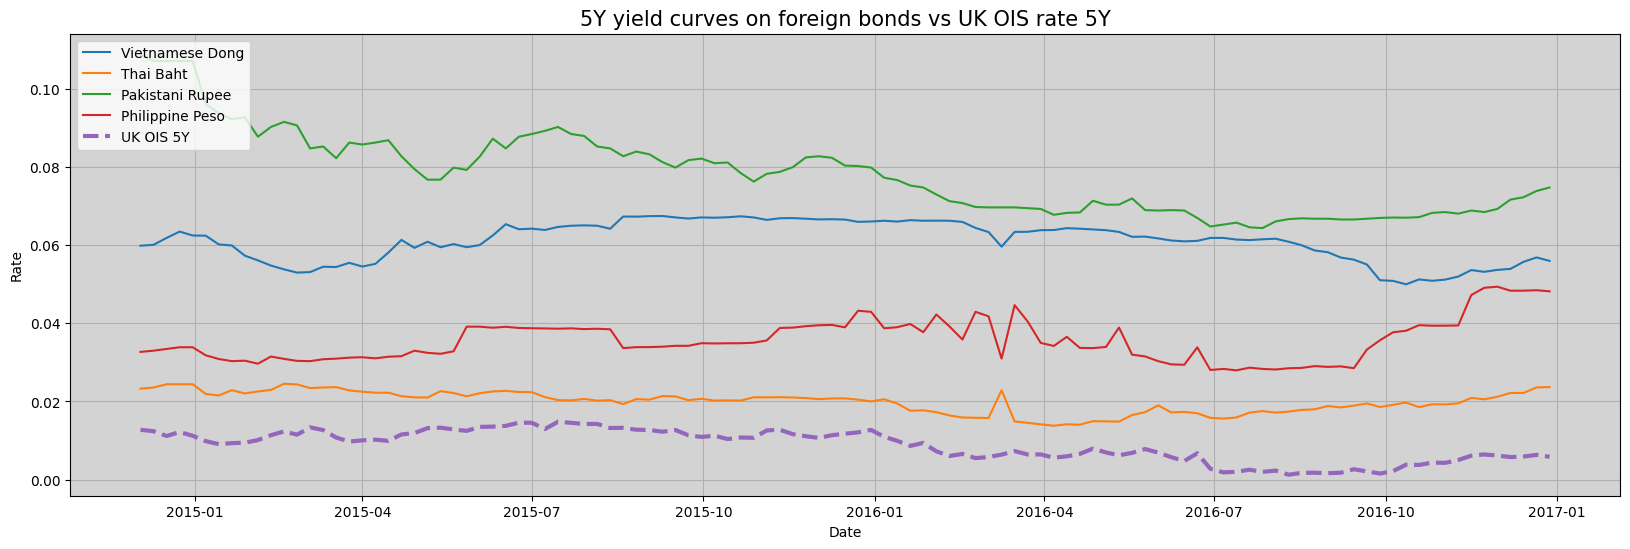

In [15]:
plt.subplots(figsize=(20,6))
plt.plot(vnm_his['Bond 5Y Yield'], label = 'Vietnamese Dong')
plt.plot(tha_his['Bond 5Y Yield'], label = 'Thai Baht')
plt.plot(pak_his['Bond 5Y Yield']['2014-12-01':], label = 'Pakistani Rupee')
plt.plot(phl_his['Bond 5Y Yield'], label = 'Philippine Peso')
plt.plot(tha_his['OIS 5Y'], '--',linewidth=3, label = 'UK OIS 5Y')
plt.ylabel("Rate")
plt.xlabel("Date")
plt.title("5Y yield curves on foreign bonds vs UK OIS rate 5Y",size=15)
plt.gca().set_facecolor('lightgray')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

### Plot historical Foreign Exchange Rate for each currency.
Vietnam's FX rate stands out with a significantly higher unit value compared to other currencies, so it is separated for a separate plot.

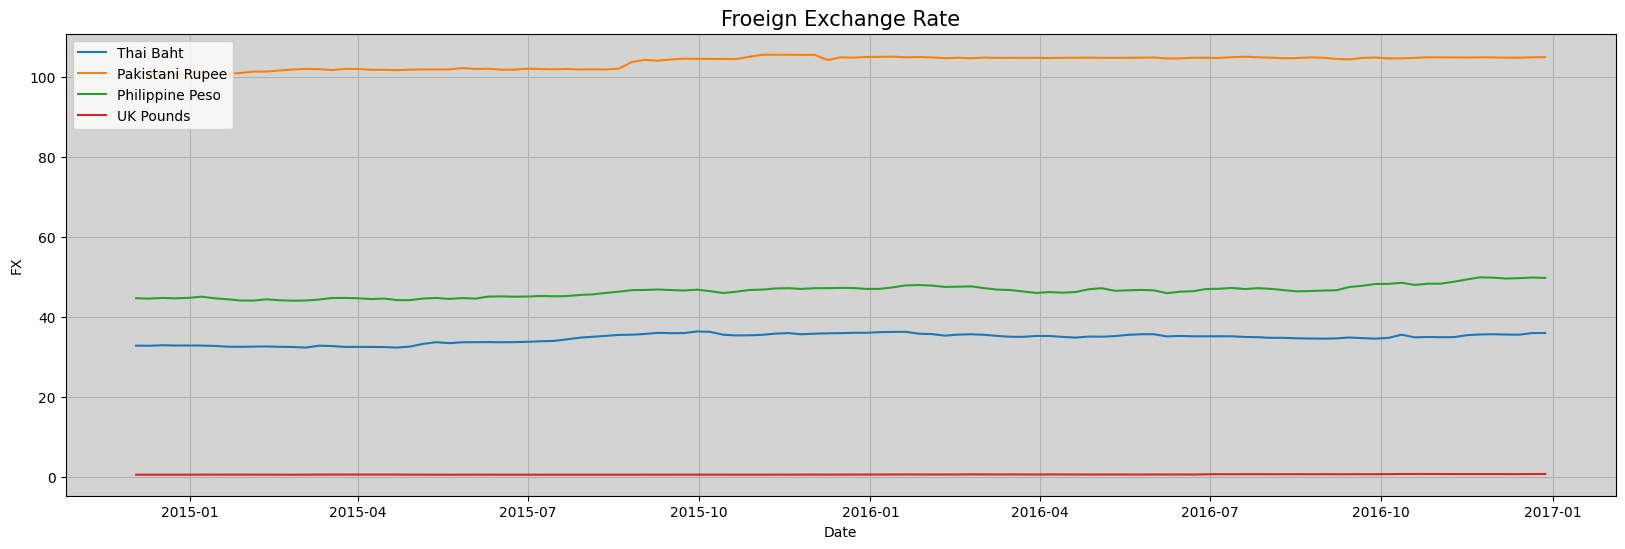

In [16]:
plt.subplots(figsize=(20,6))
plt.plot(tha_his['FX'], label = 'Thai Baht')
plt.plot(pak_his['FX']['2014-12-01':], label = 'Pakistani Rupee')
plt.plot(phl_his['FX'], label = 'Philippine Peso')
plt.plot(tha_his['USDGBP'], label = 'UK Pounds')
plt.ylabel("FX")
plt.xlabel("Date")
plt.title("Froeign Exchange Rate",size=15)
plt.gca().set_facecolor('lightgray')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

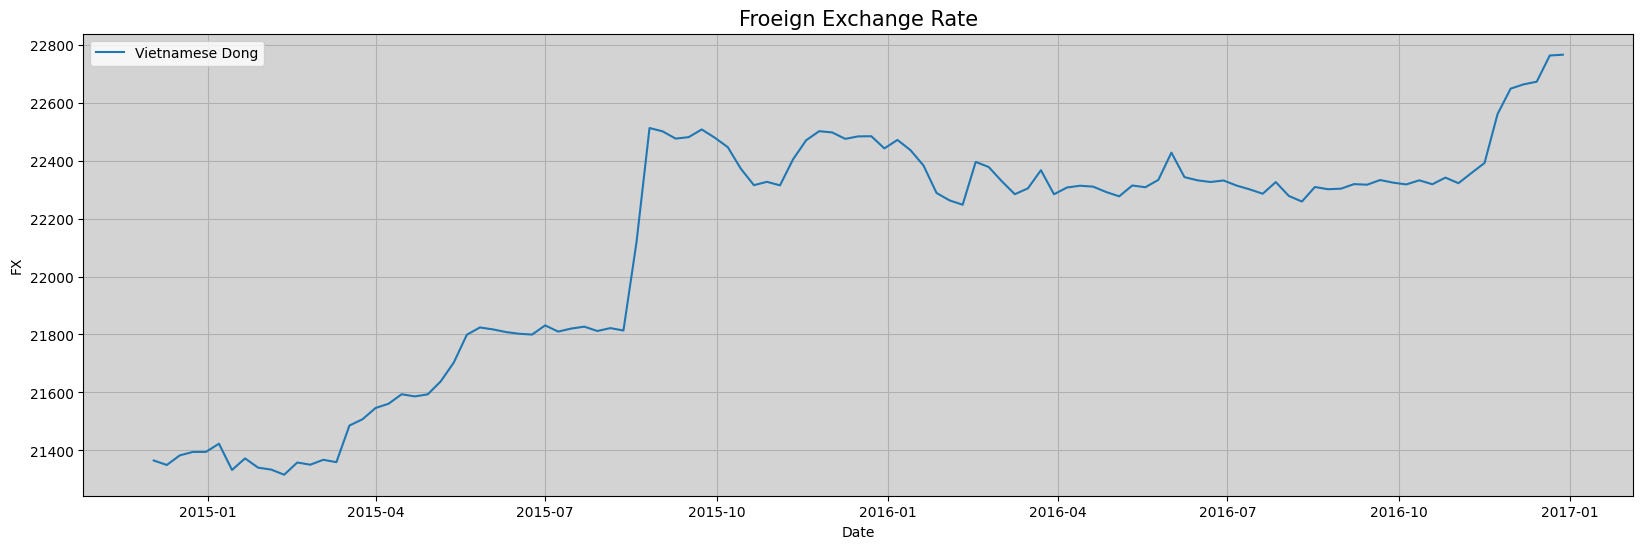

In [17]:
plt.subplots(figsize=(20,6))
plt.plot(vnm_his['FX'], label = 'Vietnamese Dong')
plt.ylabel("FX")
plt.xlabel("Date")
plt.title("Froeign Exchange Rate",size=15)
plt.gca().set_facecolor('lightgray')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

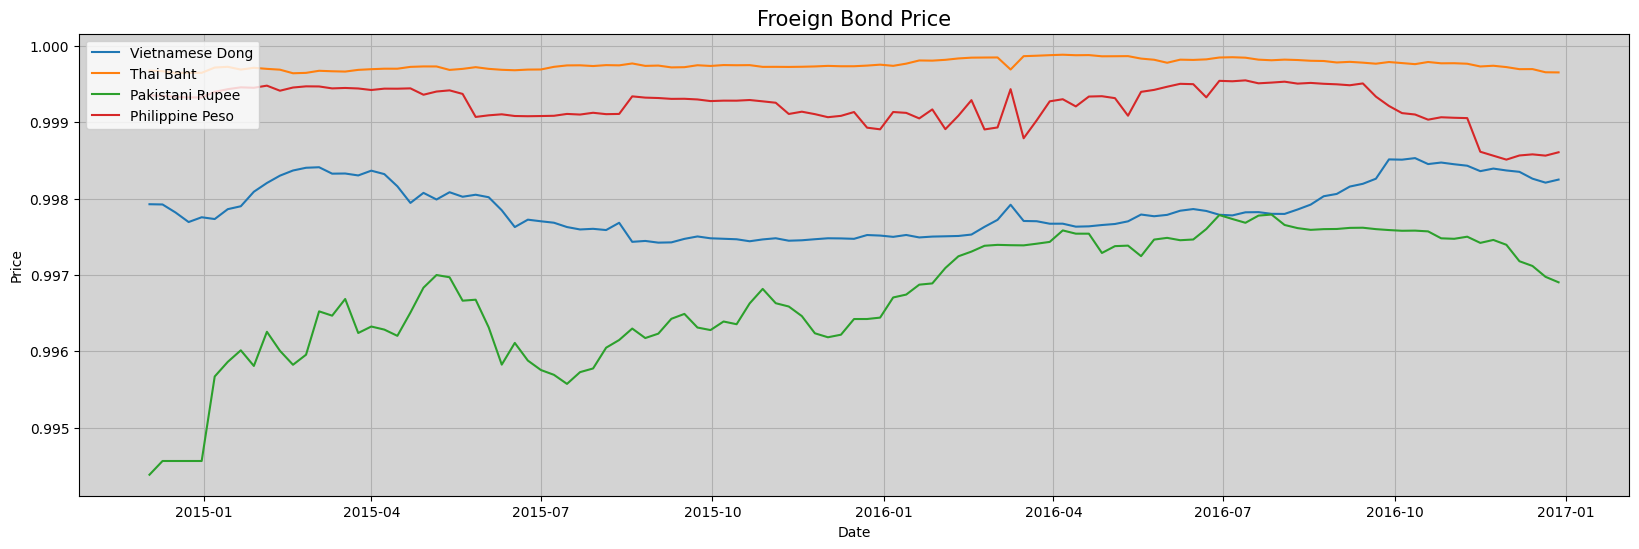

In [18]:
plt.subplots(figsize=(20,6))
plt.plot(vnm_his['Bond Price'], label = 'Vietnamese Dong')
plt.plot(tha_his['Bond Price'], label = 'Thai Baht')
plt.plot(pak_his['Bond Price']['2014-12-01':], label = 'Pakistani Rupee')
plt.plot(phl_his['Bond Price'], label = 'Philippine Peso')
plt.ylabel("Price")
plt.xlabel("Date")
plt.title("Froeign Bond Price",size=15)
plt.gca().set_facecolor('lightgray')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

## 3. Carry Trade Strategy

Trading Idea: Borrowing UK pounds with interest rate of OIS+50bp, 5x leverage lending to foreign bonds (Vietnamese Dong, Thai Baht, Pak- istani Rupee and Philippine Peso) getting interest at 5y treasury rate. Hold position only when lending currency 5Y swap rate is 50bp higher than the 5Y swap rate in the funding currency. Close out position at week end.

In the borrowing (funding) currency, assume a rate of OIS+50bp, paid on 4/5 the notional amount (5x leverage) in the borrowing currency for each active position. In the lending currency, assume the schedule has a coupon every quarter at the 5Y swap rate, or (optionally) the 5Y treasury rate.
Weeks in which the 5Y swap rate of the lending currency is less than 50bp higher than the 5Y swap rate in the funding currency will be assumed to have no position
At the end of each week, assume you sell out of the position before opening a new one. You therefore need to tally accrued interest at the borrow and lend rates, and then compute mark-to-market for the swap exit.


- Total Investing Capital Each Week: US$ 10 MM notional

- Borrowing Capital = 4/5 * Investing Capital = US$ 8 MM notional 
- Borrowing Interest Rate = OIS + 50bp

- Bond PNL = Week end Bond price in USD - Starting Bond price in USD
- FX PNL = Investing Capital in USD - Investing Capital in USD week end (flipped because we are shorting it)

- PNL = Week-end Cash in USD - Starting Cash in USD


In [19]:
def carry_trade_table(df):
    
    total_capital = 10e6
    borrow_capital = 4/5 * total_capital

    df['Lending Currency'] = total_capital * df['FX']
    df['Bond Amount'] = (df['Lending Currency'] / df['Bond Price']).fillna(0)
    df['Position'] = np.where(df['Bond 5Y Yield']-df['OIS 5Y'] > 0.005, 1, 0)
    df['Bond Bought (Q)'] = df['Bond Amount'] * df['Position']
    df['Lending Currency 1W'] = (df['Bond Bought (Q)'].shift(1) * df['Bond Price 1W']).fillna(0)
    df['Lending Currency 1W (USD)'] = df['Lending Currency 1W'] / df['FX']   
    df['Bond PNL (USD)'] = (df['Lending Currency 1W (USD)'] - 10e6) * df['Position'].shift(1)
    df['Cumulative Bond PNL (USD)'] = df['Bond PNL (USD)'].cumsum()
 
    df['Total Investment (USD)'] = 10e6 * df['Position']
    df['Total Capital (GBP)'] = df['Total Investment (USD)'] * df['USDGBP']
    df['Borrowing Capital (GBP)'] = 3/4 * df['Total Capital (GBP)']
    df['Borrow Interest Rate'] = (df['OIS 1M'] + 0.005)/52
    df['Funding Interest (GBP)'] = (df['Borrowing Capital (GBP)'].shift(1) * df['Borrow Interest Rate'].shift(1)) * df['Position'].shift(1)
    df['Funding Interest (USD)'] = df['Funding Interest (GBP)']/df['USDGBP']
    df['Cumulative Interest'] = df['Funding Interest (USD)'].cumsum()

    df['Investing Capital 1W (USD)'] = df['Total Capital (GBP)'].shift(1)/df['USDGBP']
    df['FX PNL'] = df['Total Investment (USD)'] - df['Total Capital (GBP)'].shift(1)/df['USDGBP']
    df['Cumulative FX PNL'] = df['FX PNL'].cumsum()

    df['PNL'] = df['Lending Currency 1W (USD)'] - df['Funding Interest (USD)'] - df['Investing Capital 1W (USD)']
    df['Cumulative PNL'] = df['PNL'].cumsum()
    return df

## 4. Trade on the sample data from 2017-01-01

In [20]:
def trading_plot(df):

    df['date'] = df.index
    plt.figure(figsize=(20, 8))
    sns.lineplot(x='date', y='Bond 5Y Yield', data=df, label='Bond 5Y Yield')
    sns.lineplot(x='date', y='OIS 5Y', data=df, label='OIS 5Y')
    sns.scatterplot(x='date', y='Bond 5Y Yield', hue='Position', data=df, marker='o', s=100, style='Position',palette={1:'green',0:'red'})
    plt.legend(title='Carry Trade')
    plt.ylabel("5Y Swap Rate")
    plt.xlabel("Date")
    plt.gca().set_facecolor('lightgray')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.show()

    plt.figure(figsize=(20, 8))
    plt.plot(df['Cumulative Bond PNL (USD)'], label = 'Cumulative Bond PNL')
    plt.legend(title='PNL')
    plt.ylabel("Million")
    plt.xlabel("Date")
    plt.gca().set_facecolor('lightgray')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.show()


In [21]:
trade_tha_sample = carry_trade_table(tha_sample)
trade_vnm_sample = carry_trade_table(vnm_sample)
trade_phl_sample = carry_trade_table(phl_sample)
trade_pak_sample = carry_trade_table(pak_sample)

## 5. Analysis

### Carry Trade #1: Borrow Pounds Buy THA Bonds

In [22]:
trade_tha_sample.tail().round(4)

,OIS 1M,OIS 5Y,USDGBP,Bond 5Y Yield,Bond Price,Bond Price 1W,FX,Lending Currency,Bond Amount,Position,...,Borrowing Capital (GBP),Borrow Interest Rate,Funding Interest (GBP),Funding Interest (USD),Cumulative Interest,Investing Capital 1W (USD),FX PNL,Cumulative FX PNL,PNL,Cumulative PNL
2022-11-23,0.0306,0.0368,0.8413,0.0242,0.9996,0.9992,36.1802,361802500.0,3.619340e+08,0,...,0.0,0.0007,0.0,0.0,292365.4768,0.0,0.0,-1.228553e+07,0.0,1.475057e+06
2022-11-30,0.0318,0.0375,0.8347,0.0224,0.9997,1.0087,35.3245,353245000.0,3.533543e+08,0,...,0.0,0.0007,0.0,0.0,292365.4768,0.0,0.0,-1.228553e+07,0.0,1.475057e+06
2022-12-07,0.0332,0.0364,0.8245,0.0212,0.9997,1.0061,34.9900,349900000.0,3.499965e+08,0,...,0.0,0.0007,0.0,0.0,292365.4768,0.0,0.0,-1.228553e+07,0.0,1.475057e+06
2022-12-14,0.0344,0.0373,0.8094,0.0209,0.9997,1.0015,34.5900,345900000.0,3.459936e+08,0,...,0.0,0.0008,0.0,0.0,292365.4768,0.0,0.0,-1.228553e+07,0.0,1.475057e+06
2022-12-21,0.0343,0.0376,0.8193,0.0195,0.9998,1.0071,34.9850,349850010.0,3.499320e+08,0,...,0.0,0.0008,0.0,0.0,292365.4768,0.0,0.0,-1.228553e+07,0.0,1.475057e+06


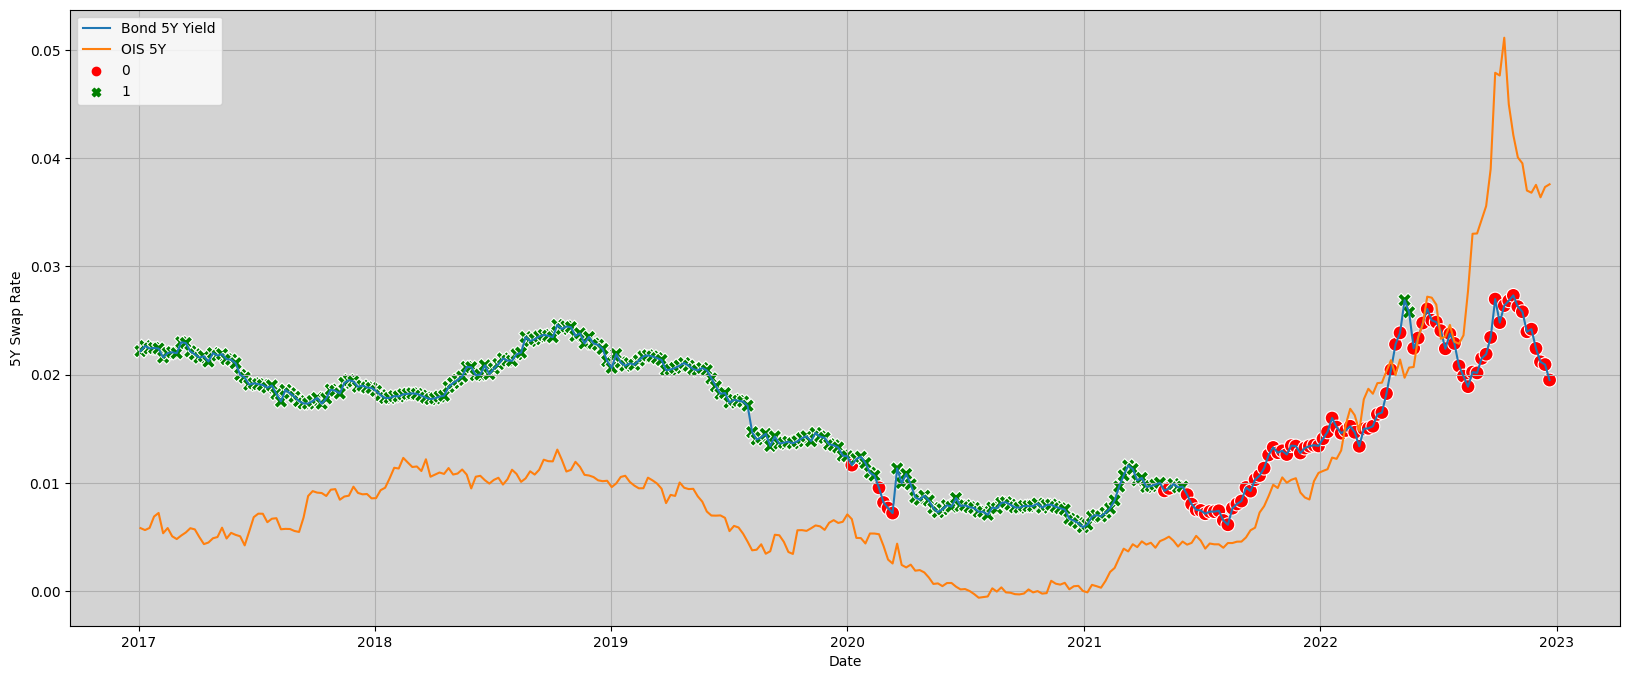

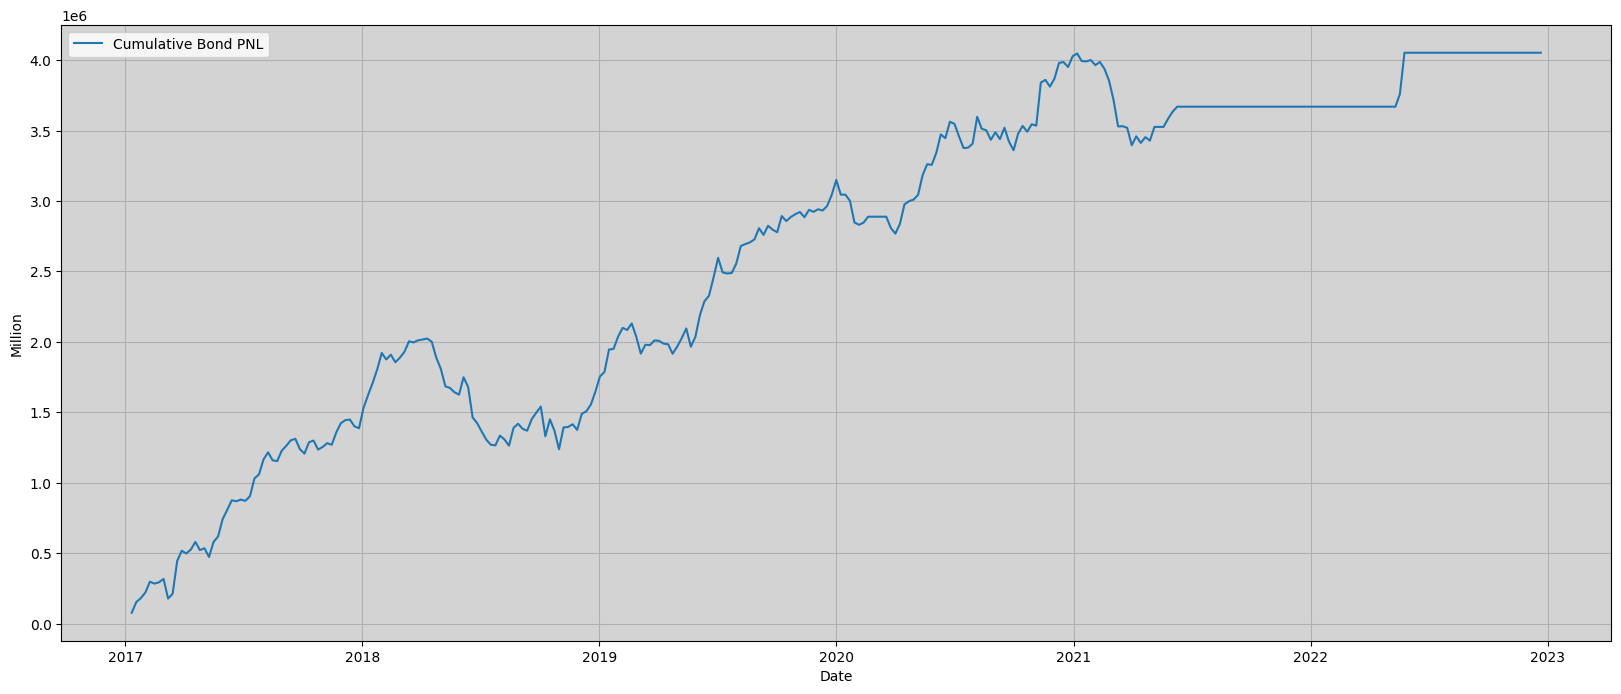

In [23]:
trading_plot(trade_tha_sample)

In [24]:
trade_tha_sample[['OIS 5Y','Bond 5Y Yield','FX','Cumulative Bond PNL (USD)','Cumulative PNL']][1:].describe()

,OIS 5Y,Bond 5Y Yield,FX,Cumulative Bond PNL (USD),Cumulative PNL
count,311.000000,311.000000,311.000000,3.110000e+02,3.110000e+02
mean,0.009639,0.016223,32.593157,2.634105e+06,1.236529e+06
std,0.009370,0.005891,1.778283,1.155726e+06,6.245728e+05
min,-0.000612,0.005900,29.851776,7.750136e+04,-5.955755e+04
25%,0.004449,0.010380,31.243750,1.547510e+06,6.558458e+05
50%,0.007156,0.017840,32.440000,2.888835e+06,1.259378e+06
75%,0.010798,0.021195,33.381138,3.669838e+06,1.733354e+06
max,0.051128,0.027320,38.123500,4.052951e+06,2.703711e+06


Comment:



Most of our trades were done before 2021 March, as the bond yield and borrowing yield spread was relatively wide and contributed to the overall profit.

The "Cumulative Bond PNL (USD)" column shows the cumulative profit and loss from the bond investment in US dollars. The mean value of 2.634105e+06 indicates an average profit of over 2.6 million US dollars. The standard deviation of 1.155726e+06 shows that the profit from bond investment had a wide range of values.

The "Cumulative PNL" column shows the cumulative profit and loss of the entire carry trade strategy, which includes both the bond investment and the foreign exchange rate. The mean value of 1.236529e+06 indicates an average profit of over 1.2 million US dollars. The standard deviation of 6.245728e+05 shows that the profit from the entire carry trade had a wide range of values.

Overall, the performance of this carry trade seems to be positive, with an average profit of over 1.2 million US dollars, but with a wide range of values.

### Carry Trade #2: Borrow Pounds Buy VNM Bonds

In [25]:
trade_vnm_sample.tail().round(4)

,OIS 1M,OIS 5Y,USDGBP,Bond 5Y Yield,Bond Price,Bond Price 1W,FX,Lending Currency,Bond Amount,Position,...,Borrowing Capital (GBP),Borrow Interest Rate,Funding Interest (GBP),Funding Interest (USD),Cumulative Interest,Investing Capital 1W (USD),FX PNL,Cumulative FX PNL,PNL,Cumulative PNL
2022-11-23,0.0306,0.0368,0.8413,0.0479,0.9988,0.9997,24847.8076,2.484781e+11,2.487824e+11,1,...,6309825.0,0.0007,4238.3695,5037.8214,322434.4894,1.001278e+07,-12777.6919,-1.429352e+06,-32109.6597,2.434795e+06
2022-11-30,0.0318,0.0375,0.8347,0.0480,0.9988,0.9990,24651.8028,2.465180e+11,2.468223e+11,1,...,6260617.5,0.0007,4325.4796,5181.7727,327616.2621,1.007860e+07,-78598.4769,-1.507950e+06,-2486.2325,2.432309e+06
2022-12-07,0.0332,0.0364,0.8245,0.0480,0.9988,0.9997,23863.5283,2.386353e+11,2.389300e+11,1,...,6183397.5,0.0007,4428.8497,5371.8644,332988.1265,1.012488e+07,-124882.8011,-1.632833e+06,209735.1339,2.642044e+06
2022-12-14,0.0344,0.0373,0.8094,0.0479,0.9988,1.0003,23504.5509,2.350455e+11,2.353345e+11,1,...,6070425.0,0.0008,4540.5918,5609.8936,338598.0201,1.018610e+07,-186103.1147,-1.818936e+06,-23149.0339,2.618895e+06
2022-12-21,0.0343,0.0376,0.8193,0.0479,0.9988,0.9997,23554.3781,2.355438e+11,2.358335e+11,1,...,6144585.0,0.0008,4599.8299,5614.4921,344212.5122,9.879308e+06,120691.6334,-1.698245e+06,103290.0965,2.722185e+06


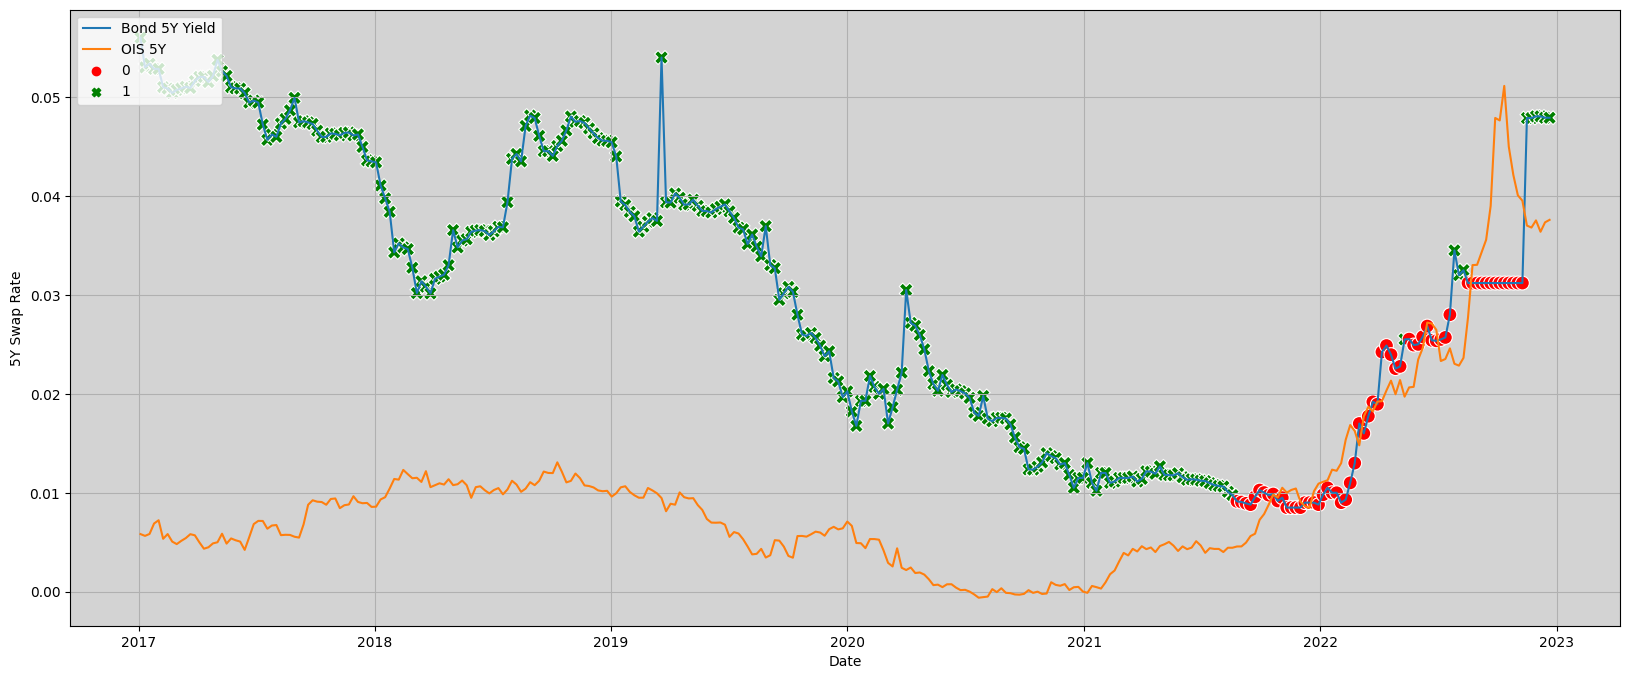

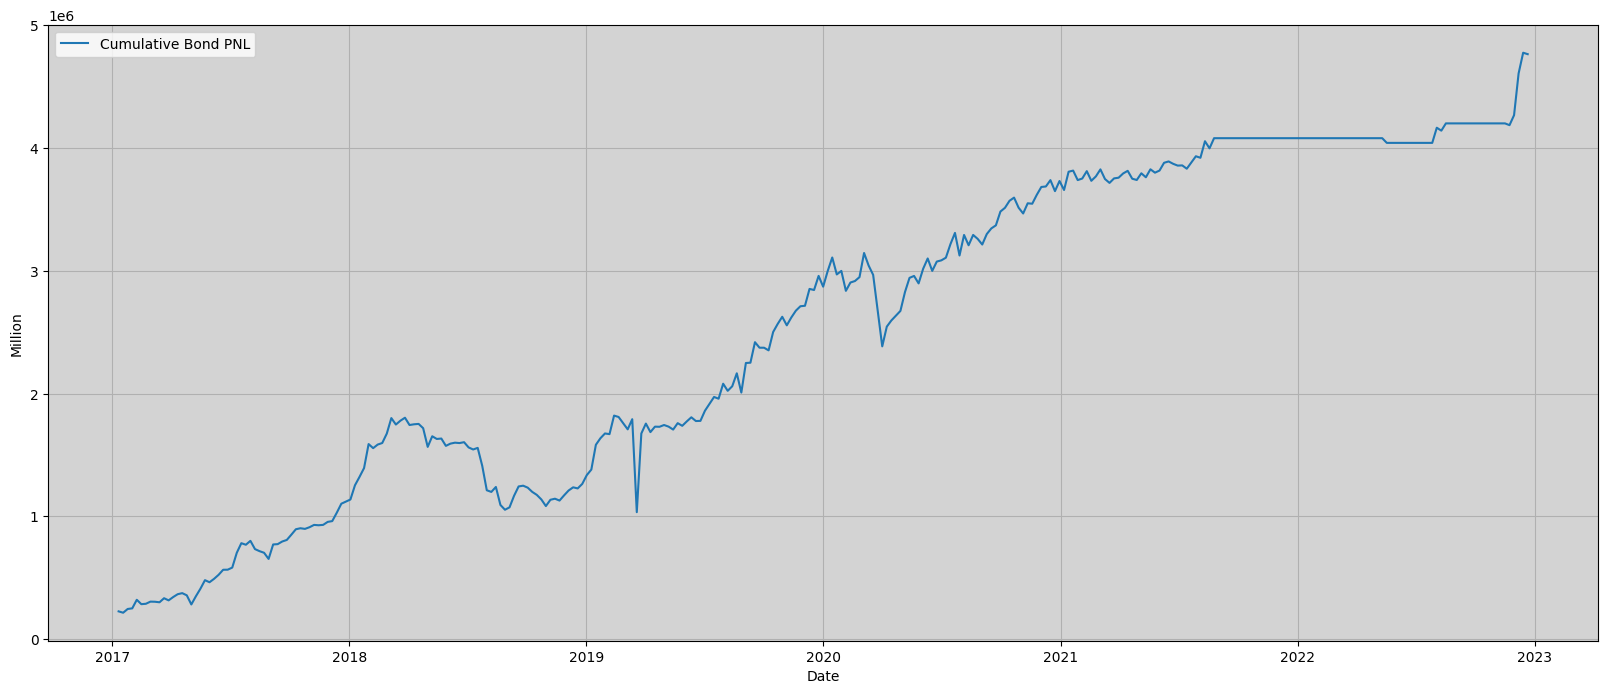

In [26]:
trading_plot(trade_vnm_sample)

In [27]:
trade_vnm_sample[['OIS 5Y','Bond 5Y Yield','FX','Cumulative Bond PNL (USD)','Cumulative PNL']][1:].describe()

,OIS 5Y,Bond 5Y Yield,FX,Cumulative Bond PNL (USD),Cumulative PNL
count,311.000000,311.000000,311.000000,3.110000e+02,3.110000e+02
mean,0.009639,0.029787,23082.802433,2.548696e+06,1.520489e+06
std,0.009370,0.014318,367.589278,1.326352e+06,9.743629e+05
min,-0.000612,0.008500,22548.966667,2.155758e+05,-2.207523e+05
25%,0.004449,0.016835,22774.437741,1.358810e+06,4.569535e+05
50%,0.007156,0.031200,23105.962672,2.678400e+06,1.964727e+06
75%,0.010798,0.043875,23242.613240,3.865177e+06,2.411706e+06
max,0.051128,0.054000,24866.343789,4.776429e+06,2.774622e+06


Comment:

The carry trade between borrowing pounds and buying Vietnamese Dong (VNM) bonds had a mean cumulative PNL (Profit and Loss) of USD 1,520,489 over a period of 311 days, according to the data in the table. The standard deviation of the cumulative PNL was USD 974,363, indicating a relatively high level of volatility in the trade's performance. The minimum cumulative PNL was -2,207,523 and the maximum cumulative PNL was 2,774,622. The 25th, 50th, and 75th percentiles of the cumulative PNL were USD 456,935, USD 1,964,727, and USD 2,411,706, respectively.

### Carry Trade #3: Borrow Pounds Buy PHL Bonds

In [28]:
trade_phl_sample.tail().round(4)

,OIS 1M,OIS 5Y,USDGBP,Bond 5Y Yield,Bond Price,Bond Price 1W,FX,Lending Currency,Bond Amount,Position,...,Borrowing Capital (GBP),Borrow Interest Rate,Funding Interest (GBP),Funding Interest (USD),Cumulative Interest,Investing Capital 1W (USD),FX PNL,Cumulative FX PNL,PNL,Cumulative PNL
2022-11-23,0.0306,0.0368,0.8413,0.0673,0.9975,1.0067,57.2325,572325010.0,5.737349e+08,1,...,6309825.0,0.0007,4238.3695,5037.8214,444943.6201,1.001278e+07,-12777.6919,71802.8239,117209.4925,632177.6921
2022-11-30,0.0318,0.0375,0.8347,0.0665,0.9976,1.0027,56.4860,564859950.0,5.662181e+08,1,...,6260617.5,0.0007,4325.4796,5181.7727,450125.3928,1.007860e+07,-78598.4769,-6795.6530,101125.5496,733303.2417
2022-12-07,0.0332,0.0364,0.8245,0.0648,0.9977,1.0061,55.4850,554849990.0,5.561223e+08,1,...,6183397.5,0.0007,4428.8497,5371.8644,455497.2572,1.012488e+07,-124882.8011,-131678.4541,136781.3100,870084.5517
2022-12-14,0.0344,0.0373,0.8094,0.0640,0.9978,1.0024,55.7160,557159910.0,5.584078e+08,1,...,6070425.0,0.0008,4540.5918,5609.8936,461107.1508,1.018610e+07,-186103.1147,-317781.5688,-185903.4245,684181.1272
2022-12-21,0.0343,0.0376,0.8193,0.0638,0.9978,0.9999,55.7065,557065030.0,5.583052e+08,1,...,6144585.0,0.0008,4599.8299,5614.4921,466721.6429,9.879308e+06,120691.6334,-197089.9354,138079.8055,822260.9328


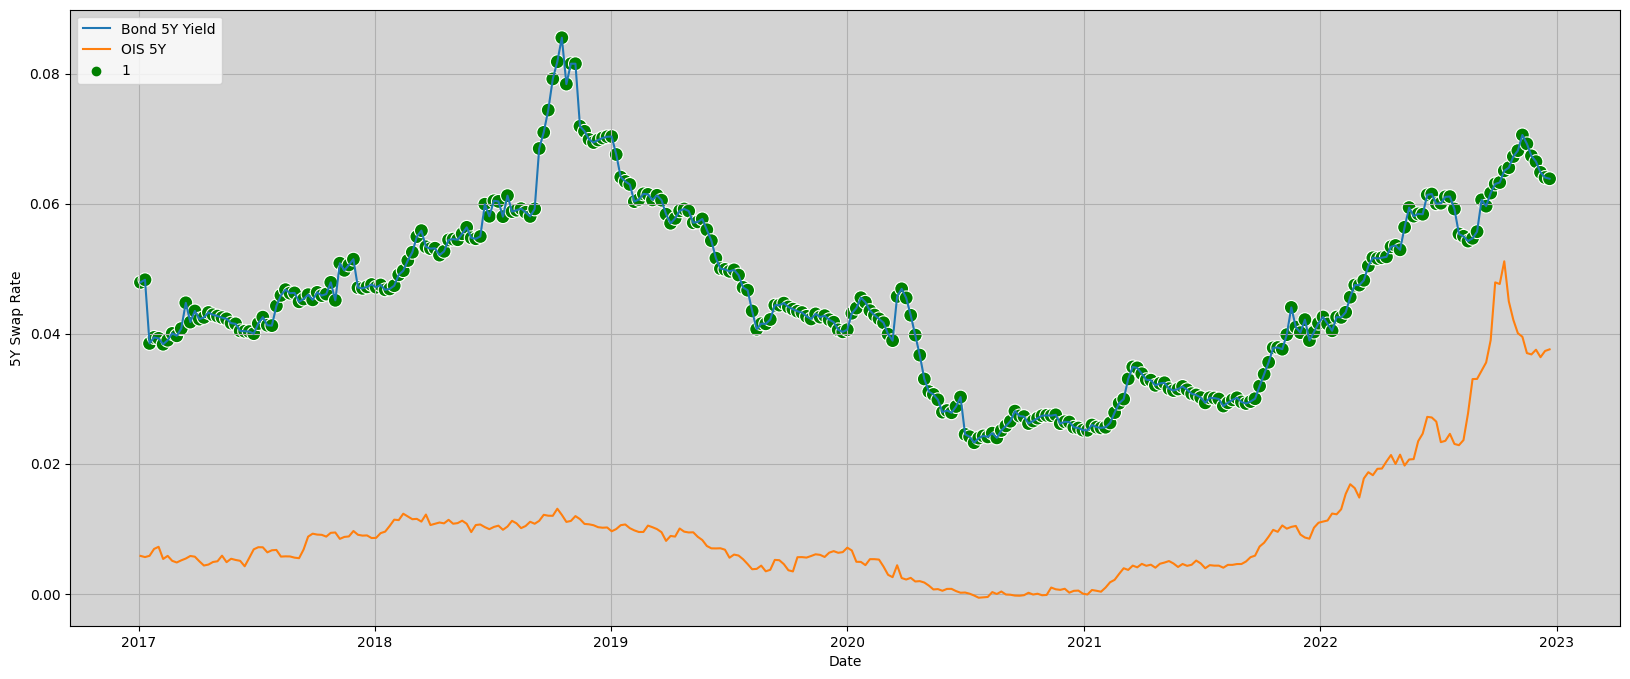

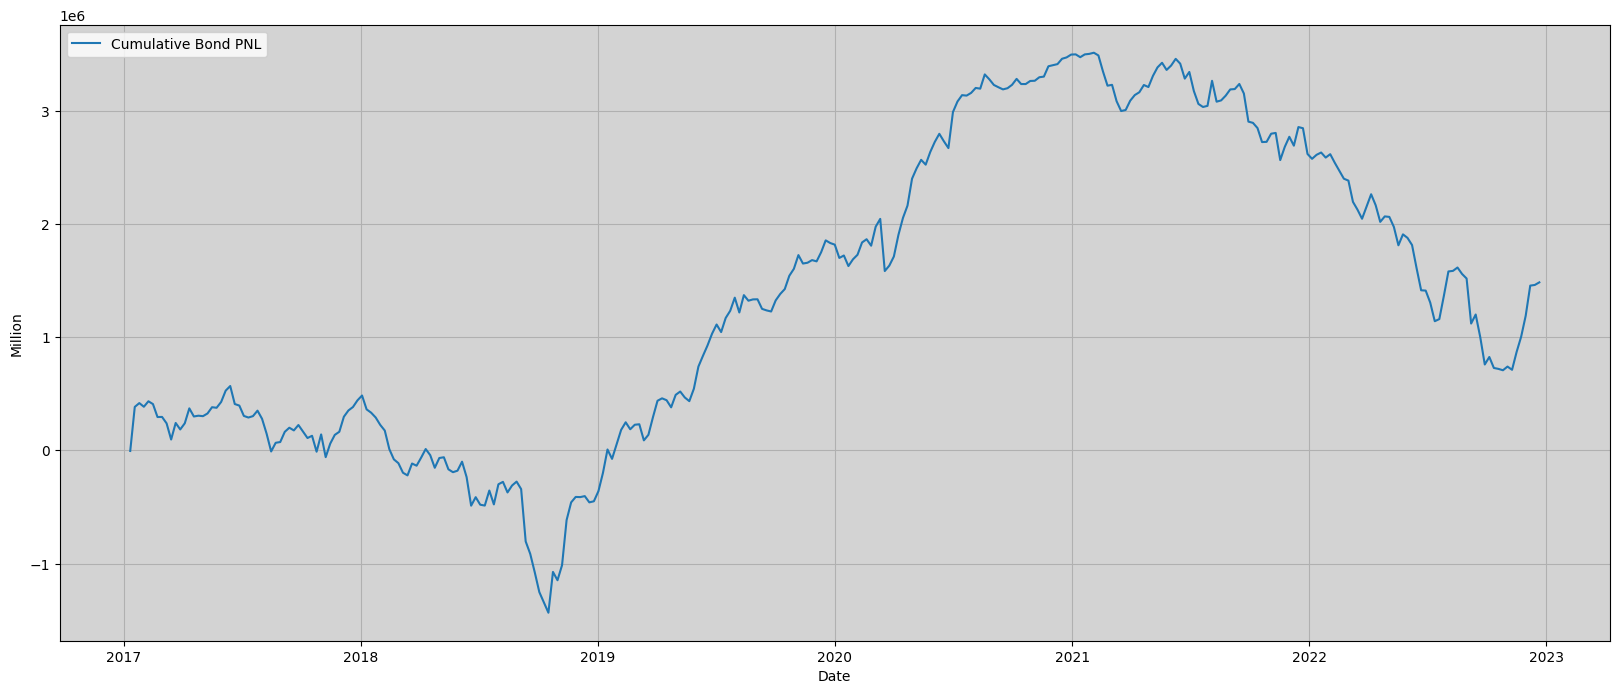

In [29]:
trading_plot(trade_phl_sample)

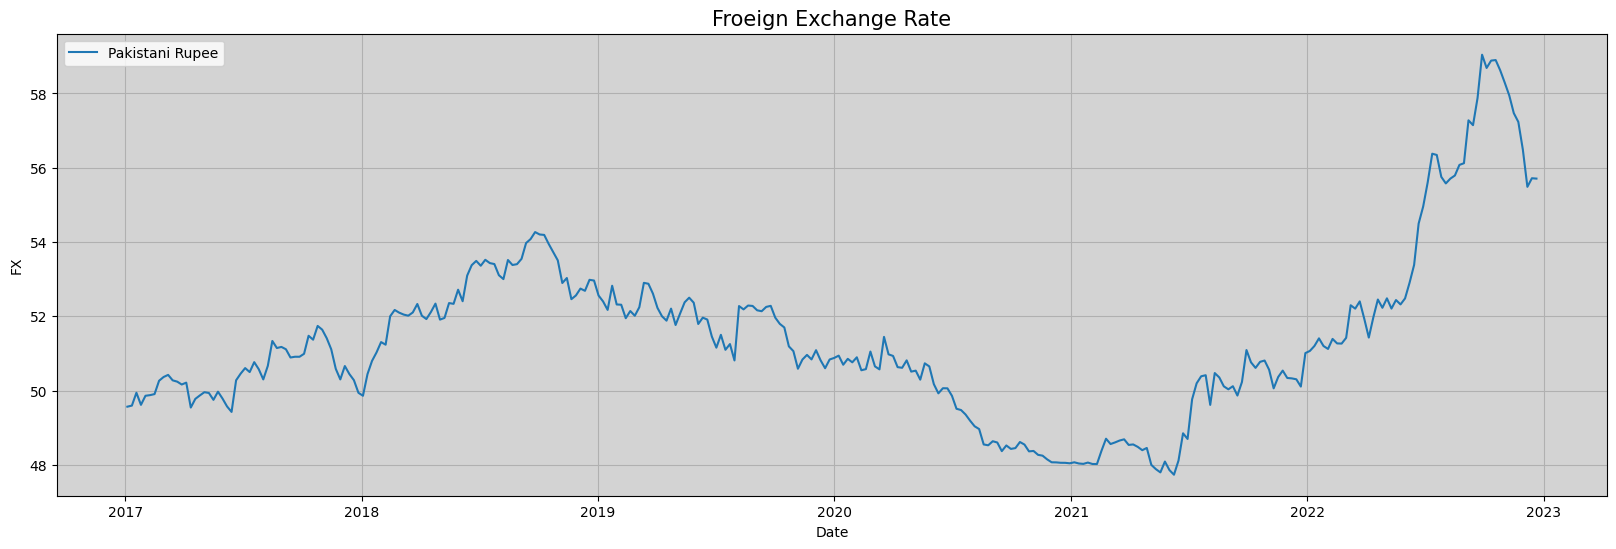

In [30]:
plt.subplots(figsize=(20,6))
plt.plot(trade_phl_sample['FX'], label = 'Pakistani Rupee')
plt.ylabel("FX")
plt.xlabel("Date")
plt.title("Froeign Exchange Rate",size=15)
plt.gca().set_facecolor('lightgray')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

In [31]:
trade_phl_sample[['OIS 5Y','Bond 5Y Yield','FX','Cumulative Bond PNL (USD)','Cumulative PNL']][1:].describe()

,OIS 5Y,Bond 5Y Yield,FX,Cumulative Bond PNL (USD),Cumulative PNL
count,311.000000,311.000000,311.000000,3.110000e+02,3.110000e+02
mean,0.009639,0.046098,51.384514,1.386310e+06,5.383518e+05
std,0.009370,0.013494,2.274504,1.345022e+06,1.178954e+06
min,-0.000612,0.023230,47.734235,-1.434410e+06,-2.278840e+06
25%,0.004449,0.037155,50.061496,2.294758e+05,-5.262139e+05
50%,0.007156,0.044750,51.049788,1.335488e+06,8.605522e+05
75%,0.010798,0.056165,52.324751,2.710362e+06,1.439281e+06
max,0.051128,0.085518,59.041503,3.516168e+06,2.549549e+06


Comment:

Based on the plot and table:

The average yield differential was 0.046098 - 0.009639 = 0.036460 per year over the period.
The standard deviation of the bond yield was 0.013494, indicating a relatively high level of volatility.
The minimum and maximum cumulative bond PNL (USD) values were -1.434410e+06 and 3.516168e+06, respectively, showing a significant range of outcomes.
The average cumulative bond PNL (USD) was 1.386310e+06.
It's important to note that this analysis only considers the yield differential and does not take into account other factors such as currency risk, credit risk, or changes in interest rates that may impact the performance of the carry trade strategy.
 
As we can tell from the plot, the cumulative PNL has a significant drawdown is not only due to the narrowing gap between the bond yield and borrowing rate, but also the depreciation of PHL.

### Carry Trade #4: Borrow Pounds Buy PAK Bonds

In [32]:
trade_pak_sample.tail().round(4)

,OIS 1M,OIS 5Y,USDGBP,Bond 5Y Yield,Bond Price,Bond Price 1W,FX,Lending Currency,Bond Amount,Position,...,Borrowing Capital (GBP),Borrow Interest Rate,Funding Interest (GBP),Funding Interest (USD),Cumulative Interest,Investing Capital 1W (USD),FX PNL,Cumulative FX PNL,PNL,Cumulative PNL
2020-03-04,0.0053,0.0029,0.7805,0.123,0.9942,0.9963,153.4673,1.534673e+09,1.543694e+09,1,...,5853547.5,0.0002,1352.9812,1733.5400,243392.8415,9.858265e+06,141734.5635,-496412.6219,180622.1355,-3.054349e+06
2020-03-11,0.0019,0.0026,0.7733,0.123,0.9942,0.9963,158.1972,1.581972e+09,1.591271e+09,1,...,5799660.0,0.0001,1163.0916,1504.0860,244896.9275,1.009291e+07,-92914.9295,-589327.5514,-372135.6705,-3.426485e+06
2020-03-18,0.0013,0.0044,0.8264,0.123,0.9942,0.9963,159.4818,1.594818e+09,1.604193e+09,1,...,6197955.0,0.0001,772.7072,935.0349,245831.9623,9.357377e+06,642623.2523,53295.7009,582886.9076,-2.843598e+06
2020-03-25,0.0007,0.0024,0.8439,0.123,0.9942,0.9963,159.2828,1.592828e+09,1.602191e+09,1,...,6329257.5,0.0001,756.5469,896.4878,246728.4501,9.792547e+06,207453.2439,260748.9448,241002.4650,-2.602596e+06
2020-04-01,0.0007,0.0022,0.8079,0.105,0.9954,1.0654,164.7993,1.647993e+09,1.655584e+09,1,...,6059542.5,0.0001,697.3426,863.1129,247591.5631,1.044511e+07,-445107.8609,-184358.9160,-88056.5442,-2.690652e+06


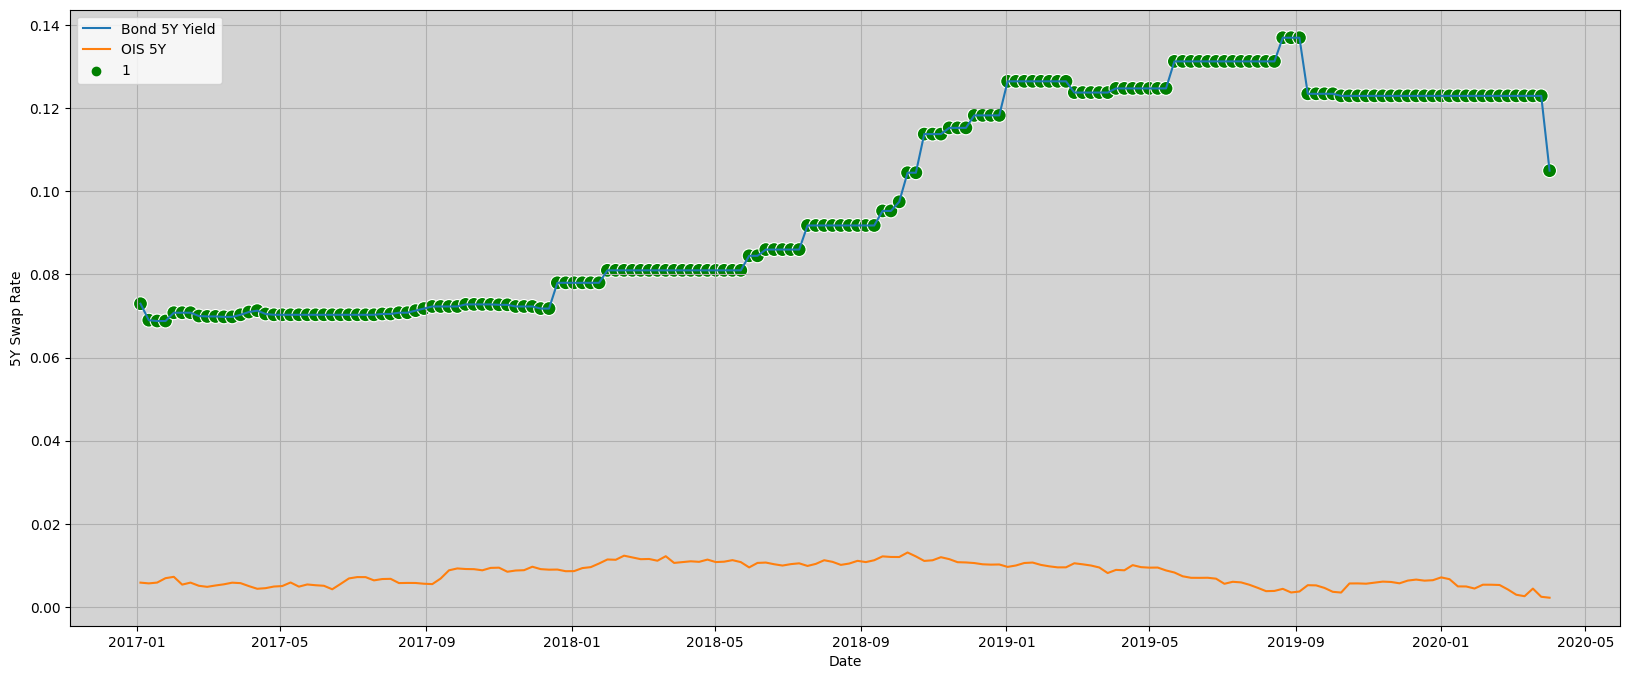

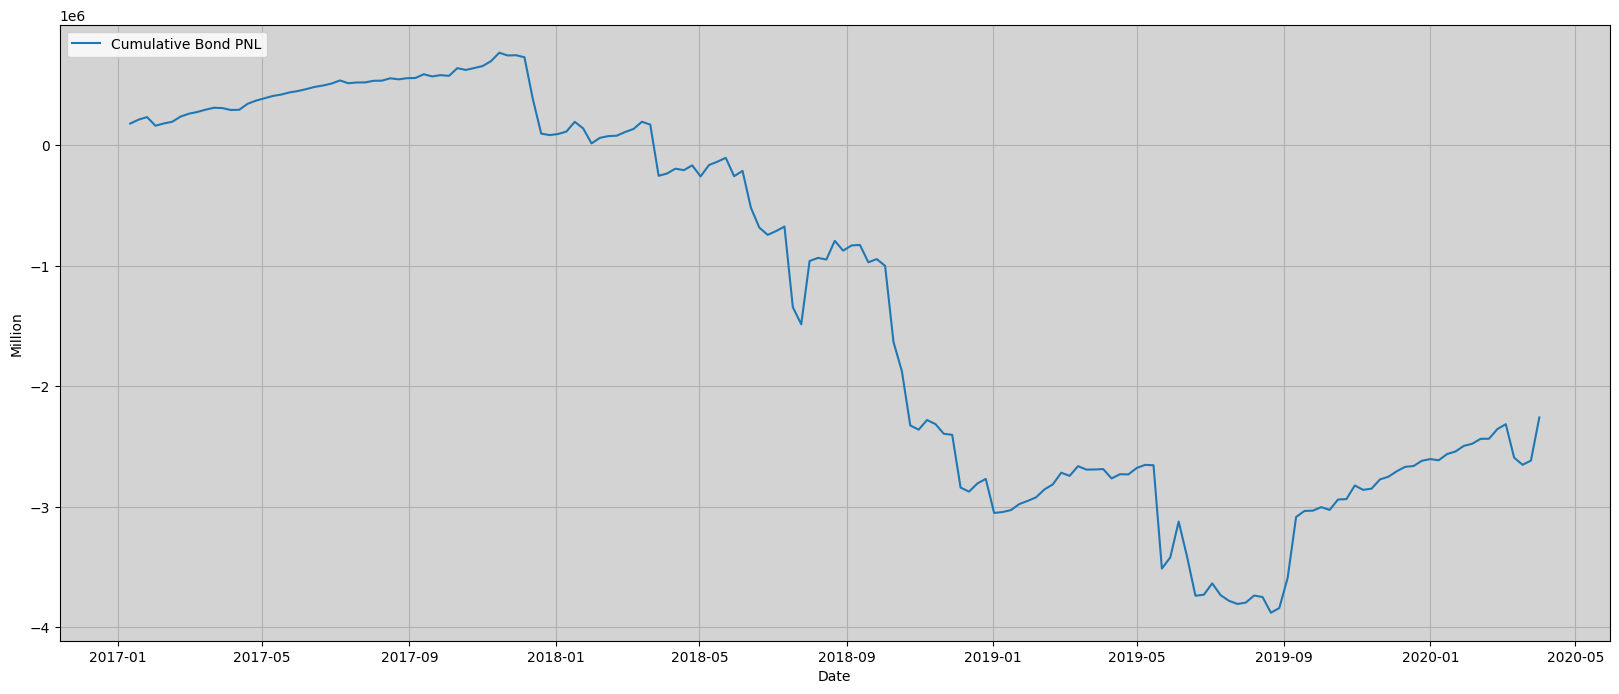

In [33]:
trading_plot(trade_pak_sample)

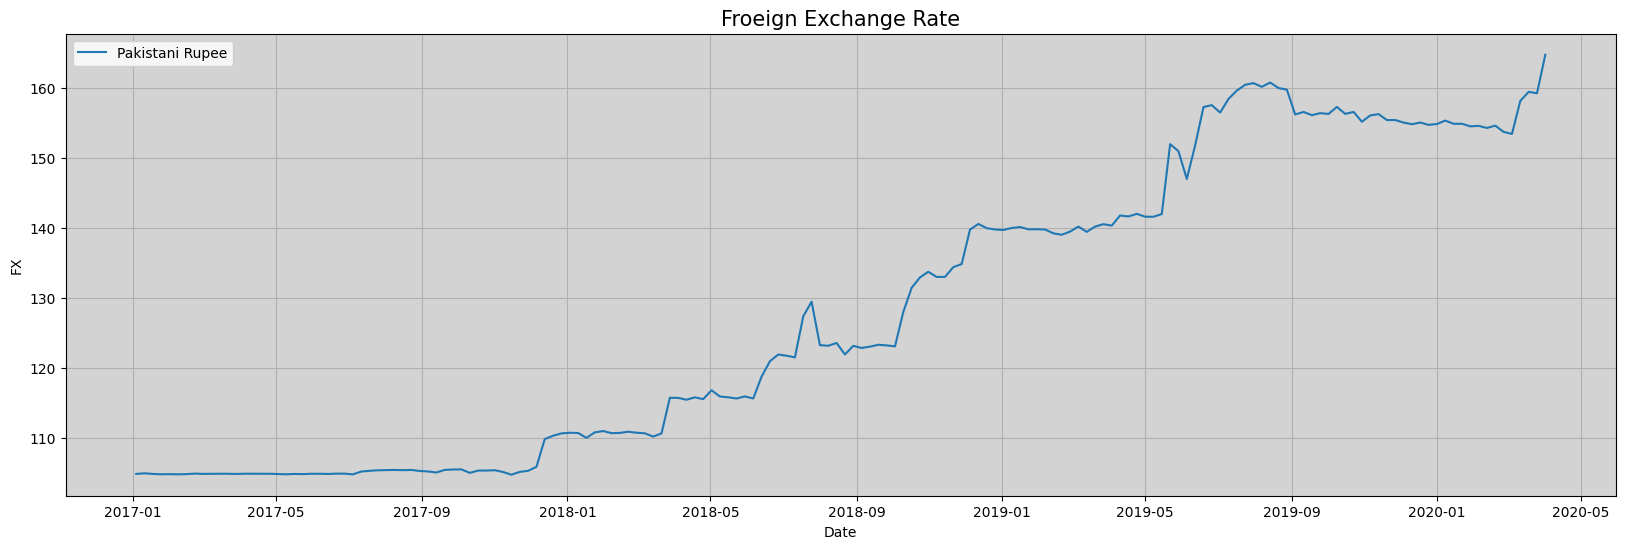

In [34]:
plt.subplots(figsize=(20,6))
plt.plot(trade_pak_sample['FX'], label = 'Pakistani Rupee')
plt.ylabel("FX")
plt.xlabel("Date")
plt.title("Froeign Exchange Rate",size=15)
plt.gca().set_facecolor('lightgray')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

In [35]:
trade_pak_sample[['OIS 5Y','Bond 5Y Yield','FX','Cumulative Bond PNL (USD)','Cumulative PNL']][1:].describe()

,OIS 5Y,Bond 5Y Yield,FX,Cumulative Bond PNL (USD),Cumulative PNL
count,169.000000,169.000000,169.000000,1.690000e+02,1.690000e+02
mean,0.007919,0.098826,128.314000,-1.287194e+06,-1.977456e+06
std,0.002683,0.024397,20.886674,1.559006e+06,1.541572e+06
min,0.002188,0.068800,104.690081,-3.878073e+06,-4.272014e+06
25%,0.005554,0.072300,105.375000,-2.731213e+06,-3.515453e+06
50%,0.008570,0.091800,123.148083,-9.454849e+05,-1.727483e+06
75%,0.010335,0.123000,152.004609,2.364030e+05,-2.143750e+05
max,0.013074,0.137000,164.799309,7.659942e+05,3.928126e+05


Comment:

Based on the data in the table, the mean spread between the OIS rate and the bond yield is 0.098826 - 0.007919 = 0.0196, which could potentially be a source of profit. However, the FX rate and its fluctuations can significantly impact the overall performance of the carry trade, as seen by the wide range of values in the "Cumulative Bond PNL (USD)" and "Cumulative PNL" columns.

As we can see from the foreign exchange, the Pakistani Rupee (PKR) experienced significant depreciation against the US dollar in 2020. There are a number of factors that contributed to this, including:

- COVID-19 Pandemic: The COVID-19 pandemic caused widespread economic disruption and reduced demand for emerging market currencies like the PKR.

- Decline in Remittances: Remittances from Pakistanis working abroad, a significant source of foreign exchange for the country, declined due to job losses and economic uncertainty caused by the pandemic.

- Balance of Payments Crisis: The PKR came under pressure in 2020 due to a widening trade deficit and a decrease in foreign currency reserves, leading to a balance of payments crisis.

- Political Instability: Political uncertainty in Pakistan also weighed on the PKR, as investors were concerned about the country's ability to address its economic challenges and maintain stability.

Overall, the combination of these factors resulted in significant depreciation of the PKR against the US dollar in 2020.

That's why it's important to take into account FX and other factors, instead of only looking at the 5y swap rate. This could cause us make bad trade that cause serious loss.
